# Importing Libraries

In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [61]:
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob 
from textblob import Word
from nltk.stem import PorterStemmer
import string
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re

In [62]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
from tensorflow.keras import Sequential,Model
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense,MaxPool1D,Dropout,Embedding,Activation,Convolution1D,add,BatchNormalization,Flatten,Reshape,Concatenate,LSTM,GRU
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,Callback
from tensorflow.keras.optimizers import Adam,SGD,Adamax,RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

# Reading Datasets

In [64]:
data = pd.read_csv("../input/stocknews/Combined_News_DJIA.csv")

In [65]:
dj = pd.read_csv("../input/stocknews/upload_DJIA_table.csv")
news= pd.read_csv("../input/stocknews/RedditNews.csv")
Top_news = pd.read_csv("../input/stocknews/Combined_News_DJIA.csv")

In [66]:
# dj.isnull().sum()

In [67]:
# Top_news.isnull().sum()

In [68]:
print(dj.shape)
print(Top_news.shape)

(1989, 7)
(1989, 27)


#  Data Preprocessing

In [69]:
dj= dj.set_index('Date')
dj.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [70]:
Final_df = Top_news.merge(dj,how="inner",on="Date")
Final_df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President

In [71]:
# Combing Headlines
headline=[]
for row in range(0,len(Final_df.index)):
    headline.append(" ".join(str(x) for x in Final_df.iloc[row,2:27]))

In [72]:
Final_df['Combined News'] = headline
Final_df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close,Combined News
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South Afric

In [73]:
Final_df = Final_df.drop(['Label','Top1','Top2','Top3','Top4','Top5','Top6','Top7','Top8','Top9','Top10','Top11','Top12','Top13','Top14','Top15','Top16','Top17','Top18','Top19','Top20','Top21','Top22','Top23','Top24','Top25'],axis=1)
Final_df


,Date,Open,High,Low,Close,Volume,Adj Close,Combined News
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...
...,...,...,...,...,...,...,...,...
1984,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,Barclays and RBS shares suspended from trading...
1985,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,"2,500 Scientists To Australia: If You Want To ..."
1986,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,Explosion At Airport In Istanbul Yemeni former...
1987,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,Jamaica proposes marijuana dispensers for tour...


In [74]:
Final_df['Open']= Final_df['Open'].diff(periods=1)
Final_df

,Date,Open,High,Low,Close,Volume,Adj Close,Combined News
0,2008-08-08,NaN,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,297.580078,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...
2,2008-08-12,52.030273,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,-148.890625,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,-100.739258,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...
...,...,...,...,...,...,...,...,...
1984,2016-06-27,-591.419921,17355.210938,17063.080078,17140.240234,138740000,17140.240234,Barclays and RBS shares suspended from trading...
1985,2016-06-28,-164.701172,17409.720703,17190.509766,17409.720703,112190000,17409.720703,"2,500 Scientists To Australia: If You Want To ..."
1986,2016-06-29,265.509765,17704.509766,17456.019531,17694.679688,106380000,17694.679688,Explosion At Airport In Istanbul Yemeni former...
1987,2016-06-30,256.740235,17930.609375,17711.800781,17929.990234,133030000,17929.990234,Jamaica proposes marijuana dispensers for tour...


In [75]:
Final_df['Volume']= Final_df['Volume'].diff(periods=1)
Final_df['High']= Final_df['High'].diff(periods=1)
Final_df['Low']= Final_df['Low'].diff(periods=1)
Final_df['Close']= Final_df['Close'].diff(periods=1)
Final_df

,Date,Open,High,Low,Close,Volume,Adj Close,Combined News
0,2008-08-08,NaN,NaN,NaN,NaN,NaN,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,297.580078,107.150391,287.490234,48.029297,-29640000.0,11782.349609,b'Why wont America and Nato help us? If they w...
2,2008-08-12,52.030273,-84.760743,-74.010742,-139.879882,-9600000.0,11642.469727,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,-148.890625,-148.569336,-148.179687,-109.509766,8960000.0,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,-100.739258,84.500000,-2.450196,82.969727,-22760000.0,11615.929688,b'All the experts admit that we should legalis...
...,...,...,...,...,...,...,...,...
1984,2016-06-27,-591.419921,-591.419921,-293.259766,-260.509766,-100260000.0,17140.240234,Barclays and RBS shares suspended from trading...
1985,2016-06-28,-164.701172,54.509765,127.429688,269.480469,-26550000.0,17409.720703,"2,500 Scientists To Australia: If You Want To ..."
1986,2016-06-29,265.509765,294.789063,265.509765,284.958985,-5810000.0,17694.679688,Explosion At Airport In Istanbul Yemeni former...
1987,2016-06-30,256.740235,226.099609,255.781250,235.310546,26650000.0,17929.990234,Jamaica proposes marijuana dispensers for tour...


In [76]:
Final_df = Final_df[Final_df.Open.notnull()]
Final_df = Final_df.reset_index(drop=True)
Final_df

,Date,Open,High,Low,Close,Volume,Adj Close,Combined News
0,2008-08-11,297.580078,107.150391,287.490234,48.029297,-29640000.0,11782.349609,b'Why wont America and Nato help us? If they w...
1,2008-08-12,52.030273,-84.760743,-74.010742,-139.879882,-9600000.0,11642.469727,b'Remember that adorable 9-year-old who sang a...
2,2008-08-13,-148.890625,-148.569336,-148.179687,-109.509766,8960000.0,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...
3,2008-08-14,-100.739258,84.500000,-2.450196,82.969727,-22760000.0,11615.929688,b'All the experts admit that we should legalis...
4,2008-08-15,79.139649,-8.390625,148.840821,43.970703,55250000.0,11659.900391,"b""Mom of missing gay man: Too bad he's not a 2..."
...,...,...,...,...,...,...,...,...
1983,2016-06-27,-591.419921,-591.419921,-293.259766,-260.509766,-100260000.0,17140.240234,Barclays and RBS shares suspended from trading...
1984,2016-06-28,-164.701172,54.509765,127.429688,269.480469,-26550000.0,17409.720703,"2,500 Scientists To Australia: If You Want To ..."
1985,2016-06-29,265.509765,294.789063,265.509765,284.958985,-5810000.0,17694.679688,Explosion At Airport In Istanbul Yemeni former...
1986,2016-06-30,256.740235,226.099609,255.781250,235.310546,26650000.0,17929.990234,Jamaica proposes marijuana dispensers for tour...


In [77]:
print(Final_df['Open'][0])
print(Final_df['Combined News'][0])

297.58007799999905
b'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?' b'Bush puts foot down on Georgian conflict' b"Jewish Georgian minister: Thanks to Israeli training, we're fending off Russia " b'Georgian army flees in disarray as Russians advance - Gori abandoned to Russia without a shot fired' b"Olympic opening ceremony fireworks 'faked'" b'What were the Mossad with fraudulent New Zealand Passports doing in Iraq?' b'Russia angered by Israeli military sale to Georgia' b'An American citizen living in S.Ossetia blames U.S. and Georgian leaders for the genocide of innocent people' b'Welcome To World War IV! Now In High Definition!' b"Georgia's move, a mistake of monumental proportions " b'Russia presses deeper into Georgia; U.S. says regime change is goal' b'Abhinav Bindra wins first ever Individual Olympic Gold Medal for India' b' U.S. ship heads for Arctic to define territory' b'Drivers in a Jerusalem taxi station threaten to quit rather th

In [79]:
stop_words = stopwords.words('english')
lemmetizer = WordNetLemmatizer()
def textclean(s):
    words = []
    s = s.strip().lower()
    s = re.sub('\[.*?\]', '', s) 
    s = re.sub('https?://\S+|www\.\S+', '', s)
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s)
    s = re.sub('\n', '', s)
    s = re.sub('\w*\d\w*', '', s)
    s = re.sub("b[(')]",'',s)
    s = re.sub('b[(")]','',s)
    words = s.split()
    words = [lemmetizer.lemmatize(word) for word in words if word not in stop_words] # removing stop words and applying lemmetization
    s = ' '.join(words)
    return s

In [80]:
Final_df['cleaned_text'] = Final_df['Combined News'].apply(textclean)
Final_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Combined News,cleaned_text
0,2008-08-11,297.580078,107.150391,287.490234,48.029297,-29640000.0,11782.349609,b'Why wont America and Nato help us? If they w...,bwhy wont america nato help u wont help u help...
1,2008-08-12,52.030273,-84.760743,-74.010742,-139.879882,-9600000.0,11642.469727,b'Remember that adorable 9-year-old who sang a...,bremember adorable sang opening ceremony fake ...
2,2008-08-13,-148.890625,-148.569336,-148.179687,-109.509766,8960000.0,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,b u refuse israel weapon attack iran report bw...
3,2008-08-14,-100.739258,84.500000,-2.450196,82.969727,-22760000.0,11615.929688,b'All the experts admit that we should legalis...,ball expert admit legalise drug bwar south ose...
4,2008-08-15,79.139649,-8.390625,148.840821,43.970703,55250000.0,11659.900391,"b""Mom of missing gay man: Too bad he's not a 2...",bmom missing gay man bad he cheerleader theyd ...


In [81]:
print(Final_df['cleaned_text'][0])

bwhy wont america nato help u wont help u help iraq bbush put foot georgian conflict bjewish georgian minister thanks israeli training fending russia bgeorgian army flees disarray russian advance gori abandoned russia without shot fired bolympic opening ceremony firework faked bwhat mossad fraudulent new zealand passport iraq brussia angered israeli military sale georgia ban american citizen living sossetia blame u georgian leader genocide innocent people bwelcome world war iv high definition bgeorgias move mistake monumental proportion brussia press deeper georgia u say regime change goal babhinav bindra win first ever individual olympic gold medal india b u ship head arctic define territory bdrivers jerusalem taxi station threaten quit rather work new bos arab bthe french team stunned phelps relay team bisrael u behind georgian aggression bdo believe tv neither russian georgian much victim briots still going montreal canada police murdered boy saturday bchina overtake u largest manuf

# Utilizing pretrained sentiment analyzer

In [82]:
!pip install vaderSentiment

In [83]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [84]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [85]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [86]:
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

In [87]:
Final_df['subjectivity'] = Final_df['cleaned_text'].apply(get_subjectivity)

In [88]:
Final_df['polarity'] = Final_df['cleaned_text'].apply(get_polarity)

In [89]:
compound=[]
neg=[]
pos=[]
neu=[]
SIA=0

for i in range (0, len(Final_df['cleaned_text'])):
    SIA= getSIA(Final_df['cleaned_text'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

In [90]:
Final_df['compound']= compound
Final_df['neg']= neg
Final_df['pos']= pos
Final_df['neu']= neu

In [91]:
Final_df

,Date,Open,High,Low,Close,Volume,Adj Close,Combined News,cleaned_text,subjectivity,polarity,compound,neg,pos,neu
0,2008-08-11,297.580078,107.150391,287.490234,48.029297,-29640000.0,11782.349609,b'Why wont America and Nato help us? If they w...,bwhy wont america nato help u wont help u help...,0.334260,0.079866,-0.9888,0.265,0.090,0.646
1,2008-08-12,52.030273,-84.760743,-74.010742,-139.879882,-9600000.0,11642.469727,b'Remember that adorable 9-year-old who sang a...,bremember adorable sang opening ceremony fake ...,0.531229,-0.036307,-0.9931,0.252,0.094,0.654
2,2008-08-13,-148.890625,-148.569336,-148.179687,-109.509766,8960000.0,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,b u refuse israel weapon attack iran report bw...,0.370301,0.016061,-0.9661,0.187,0.102,0.710
3,2008-08-14,-100.739258,84.500000,-2.450196,82.969727,-22760000.0,11615.929688,b'All the experts admit that we should legalis...,ball expert admit legalise drug bwar south ose...,0.328388,0.024498,-0.9805,0.227,0.121,0.652
4,2008-08-15,79.139649,-8.390625,148.840821,43.970703,55250000.0,11659.900391,"b""Mom of missing gay man: Too bad he's not a 2...",bmom missing gay man bad he cheerleader theyd ...,0.448654,-0.041201,-0.9757,0.243,0.134,0.623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,2016-06-27,-591.419921,-591.419921,-293.259766,-260.509766,-100260000.0,17140.240234,Barclays and RBS shares suspended from trading...,barclays rb share suspended trading tanking po...,0.349394,-0.006098,-0.9839,0.222,0.119,0.659
1984,2016-06-28,-164.701172,54.509765,127.429688,269.480469,-26550000.0,17409.720703,"2,500 Scientists To Australia: If You Want To ...",scientist australia want save great barrier re...,0.329909,0.039465,-0.9583,0.179,0.141,0.681
1985,2016-06-29,265.509765,294.789063,265.509765,284.958985,-5810000.0,17694.679688,Explosion At Airport In Istanbul Yemeni former...,explosion airport istanbul yemeni former presi...,0.387107,0.050125,-0.9943,0.263,0.125,0.613
1986,2016-06-30,256.740235,226.099609,255.781250,235.310546,26650000.0,17929.990234,Jamaica proposes marijuana dispensers for tour...,jamaica proposes marijuana dispenser tourist a...,0.377540,0.018968,-0.9982,0.302,0.088,0.609


Normalise numerical feature

In [92]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df):
    sc = MinMaxScaler()
    sc.fit(df)
    df = sc.transform(df)
    return df

In [93]:
def unnormalize(price):
    max_price= max(dj['Open'])
    min_price= min(dj['Open'])
    price= price * (max_price-min_price) + min_price
    return price

In [94]:
Final_df['Open'] = normalize_data(Final_df['Open'].values.reshape(-1,1))
Final_df['Close'] = normalize_data(Final_df['Close'].values.reshape(-1,1))
Final_df['High'] = normalize_data(Final_df['High'].values.reshape(-1,1))
Final_df['Low'] = normalize_data(Final_df['Low'].values.reshape(-1,1))
Final_df['Volume'] = normalize_data(Final_df['Volume'].values.reshape(-1,1))
Final_df.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close,Combined News,cleaned_text,subjectivity,polarity,compound,neg,pos,neu
0,2008-08-11,0.628837,0.624454,0.762813,0.481716,0.477806,11782.349609,b'Why wont America and Nato help us? If they w...,bwhy wont america nato help u wont help u help...,0.334260,0.079866,-0.9888,0.265,0.090,0.646
1,2008-08-12,0.483934,0.452904,0.562512,0.372090,0.495330,11642.469727,b'Remember that adorable 9-year-old who sang a...,bremember adorable sang opening ceremony fake ...,0.531229,-0.036307,-0.9931,0.252,0.094,0.654
2,2008-08-13,0.365368,0.395866,0.521416,0.389808,0.511561,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,b u refuse israel weapon attack iran report bw...,0.370301,0.016061,-0.9661,0.187,0.102,0.710
3,2008-08-14,0.393783,0.604207,0.602162,0.502100,0.483822,11615.929688,b'All the experts admit that we should legalis...,ball expert admit legalise drug bwar south ose...,0.328388,0.024498,-0.9805,0.227,0.121,0.652
4,2008-08-15,0.499932,0.521172,0.685990,0.479348,0.552040,11659.900391,"b""Mom of missing gay man: Too bad he's not a 2...",bmom missing gay man bad he cheerleader theyd ...,0.448654,-0.041201,-0.9757,0.243,0.134,0.623


In [95]:
y = Final_df['Open']



# APPROACH 2: USING ONLY NUMERICAL FEATURE

In [96]:
numerical_feature = ['Open','High','Low','Close','Volume']
df_num = Final_df[numerical_feature] 
df_num

,Open,High,Low,Close,Volume
0,0.628837,0.624454,0.762813,0.481716,0.477806
1,0.483934,0.452904,0.562512,0.372090,0.495330
2,0.365368,0.395866,0.521416,0.389808,0.511561
3,0.393783,0.604207,0.602162,0.502100,0.483822
4,0.499932,0.521172,0.685990,0.479348,0.552040
...,...,...,...,...,...
1983,0.104226,0.000000,0.441029,0.301715,0.416050
1984,0.356038,0.577399,0.674126,0.610910,0.480508
1985,0.609911,0.792185,0.750634,0.619940,0.498645
1986,0.604736,0.730783,0.745244,0.590975,0.527030


Dividing the dataset to features and target

In [97]:
#Load data for numerical
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(0,len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] -  test_set_size;
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0]#take only the open price as target variable
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,0]#take only the open price as target variable
    
    return [x_train, y_train, x_test, y_test]

In [98]:
seq_len = 30 # choose sequence length
test_set_size_percentage = 20
x_train_num_1, y_train_num_1, x_test_num_1, y_test_num_1 = load_data(df_num, seq_len)
print('x_train.shape = ',x_train_num_1.shape)
print('y_train.shape = ', y_train_num_1.shape)
print('x_test.shape = ', x_test_num_1.shape)
print('y_test.shape = ',y_test_num_1.shape)

x_train.shape =  (1566, 30, 5)
y_train.shape =  (1566,)
x_test.shape =  (392, 30, 5)
y_test.shape =  (392,)


Trying different models

In [99]:
# Initialising the RNN
model_ap2 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model_ap2.add(LSTM(units = 32,activation ='relu',return_sequences = True, 
                      input_shape = (x_train_num_1.shape[1], x_train_num_1.shape[2])))

# Adding the second LSTM layer and some Dropout regularisation
model_ap2.add(LSTM(units = 16, activation ='relu'))

# Adding the output layer
model_ap2.add(Dense(units = 1))

# Compiling the RNN
model_ap2.compile(optimizer = 'adam', loss = 'mean_squared_error', 
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [100]:
print(model_ap2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 32)            4864      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
#Fitting the RNN to the Training set
history_ap2 = model_ap2.fit(x_train_num_1, y_train_num_1,validation_split=0.2, epochs = 30,
                           batch_size = 32)

Epoch 1/30
40/40 [==============================] - 7s 134ms/step - loss: 0.1100 - root_mean_squared_error: 0.3317 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 2/30
40/40 [==============================] - 6s 141ms/step - loss: 0.0078 - root_mean_squared_error: 0.0880 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 3/30
40/40 [==============================] - 5s 133ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 4/30
40/40 [==============================] - 5s 135ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 5/30
40/40 [==============================] - 5s 123ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 6/30
40/40 [==============================] - 5s 136ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0037 - val_

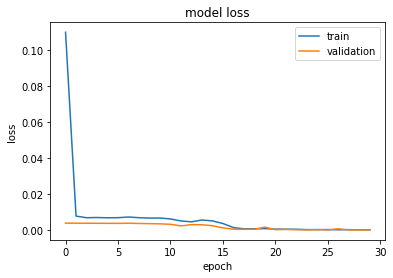

In [102]:
plt.subplots() # open a new plot
plt.plot(history_ap2.history['loss'])
plt.plot(history_ap2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [103]:
score_ap2 = model_ap2.evaluate(x_test_num_1, y_test_num_1, verbose=1)
score_ap2

13/13 [==============================] - 0s 11ms/step - loss: 2.6927e-04 - root_mean_squared_error: 0.0164


[0.0002692669804673642, 0.016409356147050858]

In [160]:
pred_ap2 = model_ap2.predict(x_test_num_1)

In [161]:
unnorm_predictions = []
for pred in pred_ap2:
    unnorm_predictions.append(unnormalize(pred))

unnorm_y_test = []
for y in y_test_num_1:
    unnorm_y_test.append(unnormalize(y))


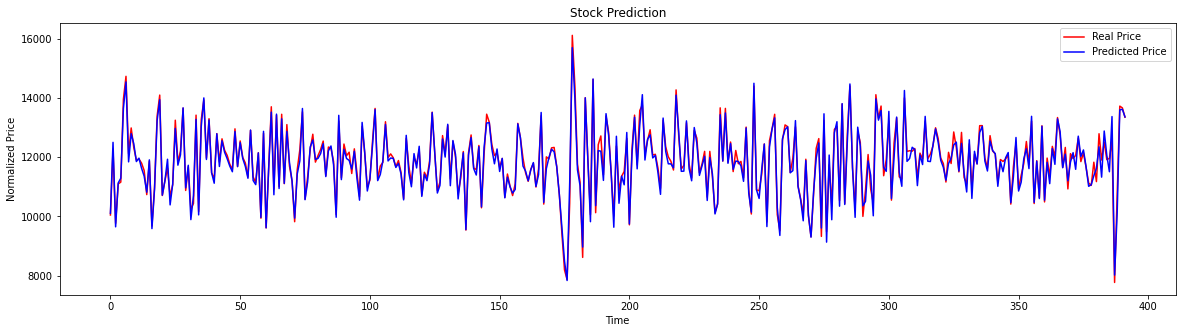

In [163]:
plt.plot(unnorm_y_test, color = 'red', label = 'Real Price')
plt.plot(unnorm_predictions, color = 'blue', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend()
plt.show()

Hypertuning the model

In [104]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=12, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-4, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
#     model.add(embedding_layer)
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu'))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="relu"))
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [105]:
import keras_tuner as kt
random_search_tuner = kt.RandomSearch(build_model, objective="val_loss", max_trials=10, overwrite=True,
directory="model_ap2", project_name="model_ap2", seed=42)
random_search_tuner.search(x_train_num_1, y_train_num_1, epochs=10, validation_split = 0.2)

Trial 10 Complete [00h 00m 56s]
val_loss: 0.2134101837873459

Best val_loss So Far: 0.0037217133212834597
Total elapsed time: 00h 11m 16s


In [106]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 11
n_neurons: 123
learning_rate: 0.0001
optimizer: adam
Score: 0.0037217133212834597


In [107]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model_ap2 = top3_models[0]

In [108]:
history_ap2_1 = best_model_ap2.fit(x_train_num_1, y_train_num_1,validation_split = 0.2, epochs=30)

Epoch 1/30
40/40 [==============================] - 8s 146ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 2/30
40/40 [==============================] - 5s 127ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 3/30
40/40 [==============================] - 6s 150ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 4/30
40/40 [==============================] - 5s 119ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 5/30
40/40 [==============================] - 5s 122ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 6/30
40/40 [==============================] - 5s 130ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0037 - val_

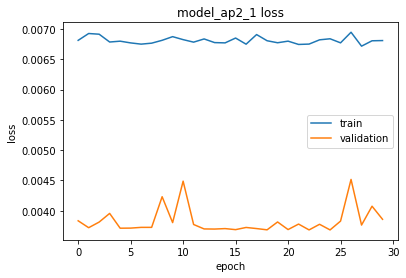

In [109]:
plt.subplots() # open a new plot
plt.plot(history_ap2_1.history['loss'])
plt.plot(history_ap2_1.history['val_loss'])
plt.title('model_ap2_1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [110]:
score_ap2_1 = best_model_ap2.evaluate(x_test_num_1, y_test_num_1)

13/13 [==============================] - 0s 11ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949


# APPROACH 3 : USING NUMERICAL + SIA SCORE FOR NEWS

In [111]:
# text_feature = Final_df['cleaned_text']
num_sia_feature = ['Open','High','Low','Close','Volume','subjectivity','polarity','compound','neg','pos','neu']
df_num_sia = Final_df[num_sia_feature]
df_num_sia

,Open,High,Low,Close,Volume,subjectivity,polarity,compound,neg,pos,neu
0,0.628837,0.624454,0.762813,0.481716,0.477806,0.334260,0.079866,-0.9888,0.265,0.090,0.646
1,0.483934,0.452904,0.562512,0.372090,0.495330,0.531229,-0.036307,-0.9931,0.252,0.094,0.654
2,0.365368,0.395866,0.521416,0.389808,0.511561,0.370301,0.016061,-0.9661,0.187,0.102,0.710
3,0.393783,0.604207,0.602162,0.502100,0.483822,0.328388,0.024498,-0.9805,0.227,0.121,0.652
4,0.499932,0.521172,0.685990,0.479348,0.552040,0.448654,-0.041201,-0.9757,0.243,0.134,0.623
...,...,...,...,...,...,...,...,...,...,...,...
1983,0.104226,0.000000,0.441029,0.301715,0.416050,0.349394,-0.006098,-0.9839,0.222,0.119,0.659
1984,0.356038,0.577399,0.674126,0.610910,0.480508,0.329909,0.039465,-0.9583,0.179,0.141,0.681
1985,0.609911,0.792185,0.750634,0.619940,0.498645,0.387107,0.050125,-0.9943,0.263,0.125,0.613
1986,0.604736,0.730783,0.745244,0.590975,0.527030,0.377540,0.018968,-0.9982,0.302,0.088,0.609


In [112]:
#Load data
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(0,len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len +1])
    
    data = np.array(data);
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] -  test_set_size;
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0]#take only the open price as target variable
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,0]#take only the open price as target variable
    
    return [x_train, y_train, x_test, y_test]

In [113]:
seq_len = 30 # choose sequence length
test_set_size_percentage = 20
x_train_num_sia, y_train_num_sia, x_test_num_sia, y_test_num_sia = load_data(df_num_sia, seq_len)
print('x_train.shape = ',x_train_num_sia.shape)
print('y_train.shape = ', y_train_num_sia.shape)
print('x_test.shape = ', x_test_num_sia.shape)
print('y_test.shape = ',y_test_num_sia.shape)

x_train.shape =  (1566, 30, 11)
y_train.shape =  (1566,)
x_test.shape =  (392, 30, 11)
y_test.shape =  (392,)


In [114]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras

In [115]:
# Initialising the RNN
model_ap3 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model_ap3.add(LSTM(units = 32,activation ='relu',return_sequences = True, 
                      input_shape = (x_train_num_sia.shape[1], x_train_num_sia.shape[2])))

# Adding the second LSTM layer and some Dropout regularisation
model_ap3.add(LSTM(units = 16, activation ='relu'))

# Adding the output layer
model_ap3.add(Dense(units = 1))

# Compiling the RNN
model_ap3.compile(optimizer = 'adam', loss = 'mean_squared_error', 
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [116]:
print(model_ap3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 32)            5632      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 8,785
Trainable params: 8,785
Non-trainable params: 0
_________________________________________________________________
None


In [117]:
# # Fitting the RNN to the Training set
history_ap3 = model_ap3.fit(x_train_num_sia, y_train_num_sia,validation_split=0.2, epochs = 30,
                           batch_size = 32)

Epoch 1/30
40/40 [==============================] - 8s 131ms/step - loss: 0.0809 - root_mean_squared_error: 0.2845 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 2/30
40/40 [==============================] - 5s 134ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632
Epoch 3/30
40/40 [==============================] - 5s 121ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 4/30
40/40 [==============================] - 5s 137ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 5/30
40/40 [==============================] - 5s 124ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 6/30
40/40 [==============================] - 6s 147ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0038 - val_

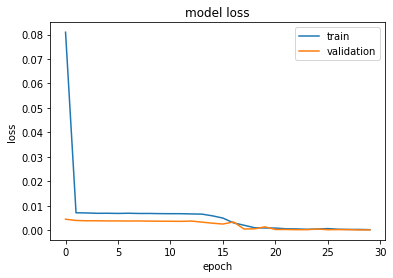

In [118]:
plt.subplots()
plt.plot(history_ap3.history['loss'])
plt.plot(history_ap3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [165]:
pred_ap3 = model_ap3.predict(x_test_num_sia)
unnorm_predictions = []
for pred in pred_ap3:
    unnorm_predictions.append(unnormalize(pred))

unnorm_y_test = []
for y in y_test_num_sia:
    unnorm_y_test.append(unnormalize(y))


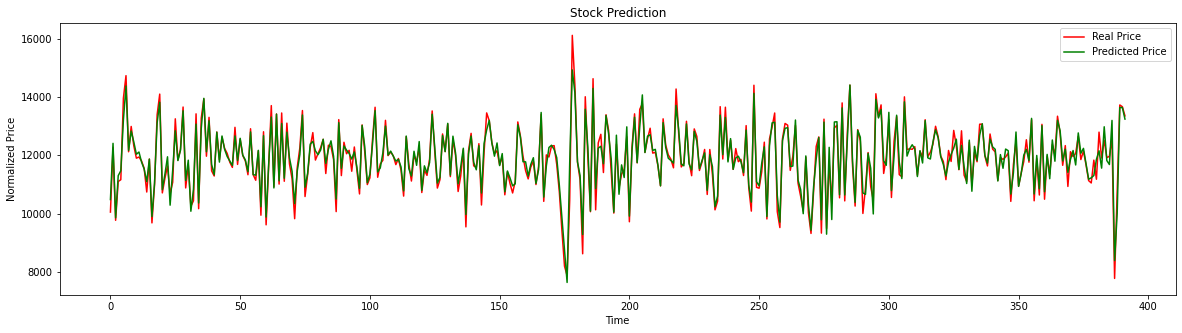

In [168]:
plt.plot(unnorm_y_test, color = 'red', label = 'Real Price')
plt.plot(unnorm_predictions, color = 'green', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.rcParams["figure.figsize"] = (10,5)
plt.legend()
plt.show()

In [119]:
score_ap3 = model_ap3.evaluate(x_test_num_sia, y_test_num_sia, verbose=1)
score_ap3

13/13 [==============================] - 0s 11ms/step - loss: 4.7282e-04 - root_mean_squared_error: 0.0217


[0.00047281821025535464, 0.0217443834990263]

In [127]:
def build_model_2(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=12, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-4, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
#     model.add(embedding_layer)
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu'))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="relu"))
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [129]:
import keras_tuner as kt
random_search_tuner_2 = kt.RandomSearch(build_model_2, objective="val_loss", max_trials=10, overwrite=True,
directory="model_ap3", project_name="model_ap3", seed=42)
random_search_tuner_2.search(x_train_num_sia, y_train_num_sia, epochs=10, validation_split = 0.2)

Trial 10 Complete [00h 00m 56s]
val_loss: 0.003939699847251177

Best val_loss So Far: 0.003747679525986314
Total elapsed time: 00h 10m 47s


In [130]:
best_trial = random_search_tuner_2.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 10
n_neurons: 124
learning_rate: 0.0001
optimizer: adam
Score: 0.003747679525986314


In [131]:
top3_models = random_search_tuner_2.get_best_models(num_models=3)
best_model_ap3 = top3_models[0]

In [132]:
history_ap3_1 = best_model_ap3.fit(x_train_num_sia, y_train_num_sia,validation_split = 0.2, epochs=30)

Epoch 1/30
40/40 [==============================] - 8s 141ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 2/30
40/40 [==============================] - 5s 124ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 3/30
40/40 [==============================] - 5s 132ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 4/30
40/40 [==============================] - 5s 122ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 5/30
40/40 [==============================] - 5s 134ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 6/30
40/40 [==============================] - 6s 138ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0037 - val_

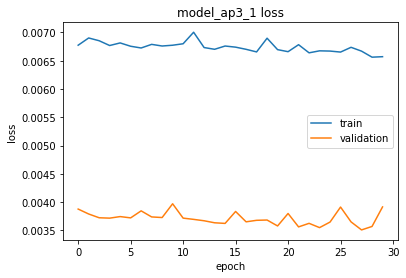

In [133]:
plt.subplots()
plt.plot(history_ap3_1.history['loss'])
plt.plot(history_ap3_1.history['val_loss'])
plt.title('model_ap3_1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [134]:
score_ap3_1 = best_model_ap3.evaluate(x_test_num_sia, y_test_num_sia)
score_ap3_1

13/13 [==============================] - 0s 11ms/step - loss: 0.0090 - root_mean_squared_error: 0.0951


[0.009045559912919998, 0.09510815143585205]

# APPROACH 4: BUILDING PARRALLEL BRANCHES (Functional API)

In [135]:
df_text = Final_df[['Open','cleaned_text']]
df_text

,Open,cleaned_text
0,0.628837,bwhy wont america nato help u wont help u help...
1,0.483934,bremember adorable sang opening ceremony fake ...
2,0.365368,b u refuse israel weapon attack iran report bw...
3,0.393783,ball expert admit legalise drug bwar south ose...
4,0.499932,bmom missing gay man bad he cheerleader theyd ...
...,...,...
1983,0.104226,barclays rb share suspended trading tanking po...
1984,0.356038,scientist australia want save great barrier re...
1985,0.609911,explosion airport istanbul yemeni former presi...
1986,0.604736,jamaica proposes marijuana dispenser tourist a...


In [136]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [137]:
def load_data_text(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(stock) - seq_len): 
        data.append(stock[index: index + seq_len +1])
    
    data = np.array(data);
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] -  test_set_size;
    
    x_train = data[:train_set_size,-1,-1]#take only the head line news on the target price day
    y_train = data[:train_set_size,-1,0]#take only the open price as target variable
    
    x_test = data[train_set_size:,-1,-1]#take only the head line news on the target price day
    y_test = data[train_set_size:,-1,0]#take only the open price as target variable
    
    return [x_train,y_train, x_test,y_test]

In [138]:
#Create train, test data for df_text
seq_len = 30 # choose sequence length
test_set_size_percentage = 20
x_train_text,y_train_text,x_test_text,y_test_text = load_data_text(df_text, seq_len)
print('x_train.shape = ',x_train_text.shape)
print('y_train.shape = ', y_train_text.shape)
print('x_test.shape = ', x_test_text.shape)
print('y_test.shape = ',y_test_text.shape)

x_train.shape =  (1566,)
y_train.shape =  (1566,)
x_test.shape =  (392,)
y_test.shape =  (392,)


In [139]:
#Tokenize to encode document
num_words_ = 5000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=num_words_, oov_token=oov_tok)
tokenizer.fit_on_texts(df_text['cleaned_text'])

x_train_text = tokenizer.texts_to_sequences(x_train_text)
x_test_text = tokenizer.texts_to_sequences(x_test_text)

In [140]:
#pad sequence
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300
trunc_type='post'
padding_type='post'

x_train_text = pad_sequences(x_train_text, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
x_test_text = pad_sequences(x_test_text, padding=padding_type, maxlen=maxlen, truncating= trunc_type)

In [142]:
#Numerical df
df_num = Final_df[['Open','High','Low','Close','Volume']]
df_num

,Open,High,Low,Close,Volume
0,0.628837,0.624454,0.762813,0.481716,0.477806
1,0.483934,0.452904,0.562512,0.372090,0.495330
2,0.365368,0.395866,0.521416,0.389808,0.511561
3,0.393783,0.604207,0.602162,0.502100,0.483822
4,0.499932,0.521172,0.685990,0.479348,0.552040
...,...,...,...,...,...
1983,0.104226,0.000000,0.441029,0.301715,0.416050
1984,0.356038,0.577399,0.674126,0.610910,0.480508
1985,0.609911,0.792185,0.750634,0.619940,0.498645
1986,0.604736,0.730783,0.745244,0.590975,0.527030


In [143]:
#Create train, test data for df_num
seq_len = 30 # choose sequence length
test_set_size_percentage = 20
x_train_num,y_train_num,x_test_num,y_test_num = load_data(df_num, seq_len)

In [144]:
#Check if num feature and text feature has the same shape
print(x_train_num.shape, x_train_text.shape)
print(y_train_num.shape, y_train_text.shape)
print(x_test_num.shape, x_test_text.shape)
print(y_test_num.shape, y_test_text.shape)

(1566, 30, 5) (1566, 300)
(1566,) (1566,)
(392, 30, 5) (392, 300)
(392,) (392,)


In [145]:
#Check if the target train, target test for num feature and text feature are the same
print(y_train_text[0], y_train_num[0])
print(y_test_text[0],y_test_num[0])


0.2297373304687414 0.2297373304687414
0.2976239871764512 0.2976239871764512


In [146]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [147]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [148]:
print(x_train_num.shape[1], x_train_num.shape[2])

30 5


In [150]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model
#Network for numerical 
num_input = Input(shape=(x_train_num.shape[1], x_train_num.shape[2]))
text_input = Input(shape =(maxlen,))

#Numerical branch
layer1_num = LSTM(units = 32,activation ='relu',return_sequences = True,input_shape = (x_train_num.shape[1], x_train_num.shape[2]))(num_input)
layer2_num = LSTM(units = 16, activation ='relu')(layer1_num)

#Text branch
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)(text_input)
layer1_text = LSTM(32, activation='relu', return_sequences=True)(embedding_layer)
layer2_text = LSTM(16, activation='relu')(layer1_text)

#Concat 2 branches
concat = concatenate([layer2_num,layer2_text])

#Output
output = Dense(units = 1)(concat)

#Model
model_ap4 = Model(inputs=[num_input, text_input], outputs =[output])

# Compiling the RNN
model_ap4.compile(optimizer = 'adam', loss = 'mean_squared_error', 
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [151]:
print(model_ap4.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 50)      1782800     input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 30, 32)       4864        input_3[0][0]                    
______________________________________________________________________________________________

In [157]:
history_ap4 = model_ap4.fit([x_train_num, x_train_text], y_train_num,validation_split = 0.2, epochs = 30,batch_size = 32)

Epoch 1/30
40/40 [==============================] - 53s 1s/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 2/30
40/40 [==============================] - 51s 1s/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 3/30
40/40 [==============================] - 50s 1s/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 4/30
40/40 [==============================] - 52s 1s/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 5/30
40/40 [==============================] - 52s 1s/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
Epoch 6/30
40/40 [==============================] - 50s 1s/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0044 - val_root_mean_sq

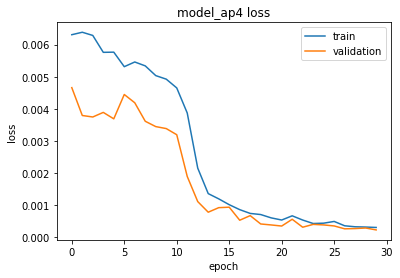

In [158]:
plt.subplots()
plt.plot(history_ap4.history['loss'])
plt.plot(history_ap4.history['val_loss'])
plt.title('model_ap4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [159]:
score_ap4 = model_ap4.evaluate([x_test_num,x_test_text], y_test_num, verbose=1)
score_ap4

13/13 [==============================] - 1s 90ms/step - loss: 5.8199e-04 - root_mean_squared_error: 0.0241


[0.000581994594540447, 0.024124564602971077]

In [169]:
pred_ap4 = model_ap4.predict([x_test_num, x_test_text])
unnorm_predictions = []
for pred in pred_ap4:
    unnorm_predictions.append(unnormalize(pred))

unnorm_y_test = []
for y in y_test_num:
    unnorm_y_test.append(unnormalize(y))


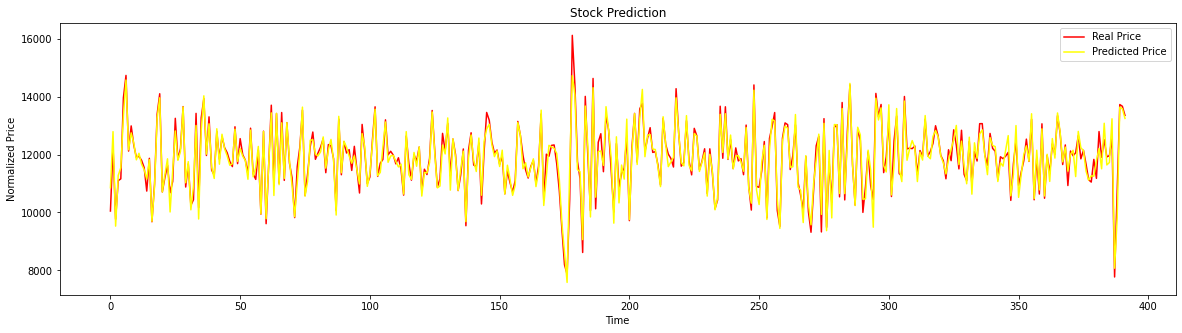

In [179]:
plt.plot(unnorm_y_test, color = 'red', label = 'Real Price')
plt.plot(unnorm_predictions, color = 'yellow', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.rcParams["figure.figsize"] = (10,5)
plt.legend()
plt.show()

In [ ]:
# def build_model_3(hp):
#     n_hidden = hp.Int("n_hidden", min_value=1, max_value=12, default=2)
#     n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
#     learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-4, sampling="log")
#     optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
#     if optimizer == "sgd":
#         optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
#     else:
#         optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     num_input = Input(shape=(x_train_num.shape[1], x_train_num.shape[2]))
#     text_input = Input(shape =(maxlen,))
#     #Numerical branch
#     layer1_num = LSTM(units = 32,activation ='relu',return_sequences = True,input_shape = (x_train_num.shape[1], x_train.shape[2]))(num_input)
#     layer2_num = LSTM(units = 16, activation ='relu')(layer1_num)
#     #Text branch
#     embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)(text_input)
#     layer1_text = LSTM(32, activation='relu', return_sequences=True)(embedding_layer)
#     layer2_text = LSTM(16, activation='relu')(layer1_text)

#     model.add(LSTM(16, activation='relu', return_sequences=True))
#     model.add(LSTM(16, activation='relu'))
#     for _ in range(n_hidden):
#         model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
#     model.add(tf.keras.layers.Dense(1, activation="relu"))
#     model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

In [ ]:
# random_search_tuner_ap4 = kt.RandomSearch(build_model_3, objective="val_loss", max_trials=10, overwrite=True,
# directory="model_ap4", project_name="model_ap4", seed=42)
# random_search_tuner.search(x_train_num_1, y_train_num_1, epochs=10, validation_split = 0.2)
# best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
# best_trial.summary()

In [ ]:
pred = model_4.predict([x_test_num, x_test_text])

In [ ]:
unnorm_predictions = []
for pred in pred:
    unnorm_predictions.append(unnormalize(pred))
    
# store back-scaled actuals
unnorm_y_test = []
for y in y_test_num:
    unnorm_y_test.append(unnormalize(y))

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss without dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(unnorm_y_test, color = 'red', label = 'Real Price')
plt.plot(unnorm_predictions, color = 'blue', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [ ]:
# TEST 2, adding dropout 
#Network for numerical 
num_input = Input(shape=(x_train_num.shape[1], x_train_num.shape[2]))
text_input = Input(shape =(maxlen,))

#Numerical branch
layer1_num = LSTM(units = 32,activation ='relu',return_sequences = True,input_shape = (x_train_num.shape[1], x_train.shape[2]))(num_input)
Dropout(0.2)(layer1_num)
layer2_num = LSTM(units = 16, activation ='relu')(layer1_num)
Dropout(0.2)(layer2_num)

#Text branch
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)(text_input)
layer1_text = LSTM(32, activation='relu', return_sequences=True)(embedding_layer)
Dropout(0.2)(layer1_text)
layer2_text = LSTM(16, activation='relu')(layer1_text)
Dropout(0.2)(layer2_text)

#Concat 2 branches
concat = concatenate([layer2_num,layer2_text])

#Output
output = Dense(units = 1)(concat)

#Model
model_5 = Model(inputs=[num_input, text_input], outputs =[output])

# Compiling the RNN
model_5.compile(optimizer = 'adam', loss = 'mean_squared_error', 
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
print(model_5.summary())

In [ ]:
#Increase the number of epoch with no change
history = model_5.fit([x_train_num, x_train_text], y_train_num,validation_split = 0.2, epochs = 10,batch_size = 32)


In [ ]:
score = model_5.evaluate([x_test_num,x_test_text], y_test_num, verbose=1)
score

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Model validation loss is consistently lower than train loss => underfitting model

In [ ]:
pred = model_5.predict([x_test_num, x_test_text])

In [ ]:
unnorm_predictions = []
for pred in pred:
    unnorm_predictions.append(unnormalize(pred))
    
# store back-scaled actuals
unnorm_y_test = []
for y in y_test_num:
    unnorm_y_test.append(unnormalize(y))

In [ ]:
plt.plot(unnorm_y_test, color = 'red', label = 'Real Price')
plt.plot(unnorm_predictions, color = 'green', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

Solving underfitting:
* Increase the number of epoch + using early stopping (avoid overfitting)
* Increase the number of node

In [ ]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model
#Network for numerical 
num_input = Input(shape=(x_train_num.shape[1], x_train_num.shape[2]))
text_input = Input(shape =(maxlen,))

#Numerical branch
layer1_num = LSTM(units = 64,activation ='relu',return_sequences = True,input_shape = (x_train_num.shape[1], x_train.shape[2]))(num_input)
layer2_num = LSTM(units = 32, activation ='relu')(layer1_num)

#Text branch
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)(text_input)
layer1_text = LSTM(64, activation='relu', return_sequences=True)(embedding_layer)
layer2_text = LSTM(32, activation='relu')(layer1_text)

#Concat 2 branches
concat = concatenate([layer2_num,layer2_text])
# layer3 = LSTM(64, activation='relu')(concat)

#Output
output = Dense(units = 1)(concat)

#Model
model_6 = Model(inputs=[num_input, text_input], outputs =[output])

# Compiling the RNN
model_6.compile(optimizer = 'adam', loss = 'mean_squared_error', 
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model_6.fit([x_train_num,x_train_text], y_train_num, epochs=100, validation_split = 0.2, callbacks=[early_stopping])

In [ ]:
score = model_6.evaluate([x_test_num,x_test_text], y_test_num, verbose=1)
score

In [ ]:
# keras.utils.plot_model(model_6, "model.png", show_shapes=True)

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

MODEL 7
Adding drop out to model 6

In [ ]:
# TEST 2, adding dropout 
#Network for numerical 
num_input = Input(shape=(x_train_num.shape[1], x_train_num.shape[2]))
text_input = Input(shape =(maxlen,))

#Numerical branch
layer1_num = LSTM(units = 64,activation ='relu',return_sequences = True,input_shape = (x_train_num.shape[1], x_train.shape[2]))(num_input)
Dropout(0.2)(layer1_num)
layer2_num = LSTM(units = 32, activation ='relu')(layer1_num)
Dropout(0.2)(layer2_num)

#Text branch
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)(text_input)
layer1_text = LSTM(64, activation='relu', return_sequences=True)(embedding_layer)
Dropout(0.2)(layer1_text)
layer2_text = LSTM(32, activation='relu')(layer1_text)
Dropout(0.2)(layer2_text)

#Concat 2 branches
concat = concatenate([layer2_num,layer2_text])

#Output
output = Dense(units = 1)(concat)

#Model
model_7 = Model(inputs=[num_input, text_input], outputs =[output])

# Compiling the RNN
model_7.compile(optimizer = 'adam', loss = 'mean_squared_error', 
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model_7.fit([x_train_num,x_train_text], y_train_num, epochs=30, validation_data = ([x_test_num, x_test_text],y_test_num), callbacks=[early_stopping])

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_7-loss with dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()